In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.model_selection import train_test_split
import pandas as pd
import torch_maml

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def loss_fn(model, data, device):
    inputs, targets = data
    predicted = model(inputs.to(device=device))
#     print(predicted, targets)
    loss = F.mse_loss(predicted, targets.to(device=device))
    return loss

In [ ]:
import torch.nn.functional as F
# Neural Network Architecture 
# Linear, output units: 40
# ReLU 
# Linear, output units: 1

class maml_m1(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 1, bias=True)
        )
    
    def get_weights(self):
        weights_dict = {}
        for name, parameter in self.net.named_parameters():
            weights_dict[name] = parameter
        return weights_dict
    
    def adapt_forward(self, x, weights_dict):
        x = F.linear(x, weights_dict['0.weight'], weights_dict['0.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['2.weight'], weights_dict['2.bias'])
        return x
    
    def forward(self, x):
        return self.net(x)

In [ ]:
# load landS file 
landS_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/landS_sample5.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)

# load landS2 file 
landS2_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/landS2_sample4.csv')
# split the data file 
landS2_train, landS2_val = train_test_split(landS2_data, test_size=0.2)

In [ ]:
# set up data loader 
batch_size = 40
nworkers = 4
landS_train_data_loader = torch.utils.data.DataLoader(landS_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS2_train_data_loader = torch.utils.data.DataLoader(landS2_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS2_val_data_loader = torch.utils.data.DataLoader(landS2_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [ ]:
# dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['landS', 'landS2']
train_data_loader['landS'] = landS_train_data_loader
train_data_loader['landS2'] = landS2_train_data_loader

val_data_loader['landS'] = landS_val_data_loader
val_data_loader['landS2'] = landS2_val_data_loader

In [ ]:
beta = 1e-5
alpha = 1e-5
nz = 7 # number of input units 
optimizer = torch_maml.IngraphGradientDescent(learning_rate=0.0001)
# optimizer = torch_maml.IngraphRMSProp(learning_rate=0.01, beta=0.0008, epsilon=0.0001)
model = maml_m1(nz).to(device=device)
maml = torch_maml.GradientCheckpointMAML(model, loss_fn, optimizer=optimizer, checkpoint_steps=5)
maml_steps = 3000

# Clip meta-learning gradients by global norm to avoid explosion
max_grad_grad_norm = 1e2


In [ ]:
inputs = None
outputs = None
batch = None
for data in landS_train_data_loader:
    input_size = data.shape[1]
#     x = data[:,:-1].clone().detach()
    ip_data = data[:,:-1].clone().detach().to(dtype=torch.float)
    inner_loop_sample = F.pad(input=ip_data, pad=(0,2,0,0), mode='constant', value=0)
#     print(inner_loop_sample)
    h_value = data[:,-1].clone().detach().to(dtype=torch.float)
    outputs = h_value.view(-1,1)
    inputs = [(inner_loop_sample, outputs)] * maml_steps
    batch = inner_loop_sample
    print(batch.shape, outputs.shape)
    break

torch.Size([40, 7]) torch.Size([40, 1])


Loss naive: 8.8527


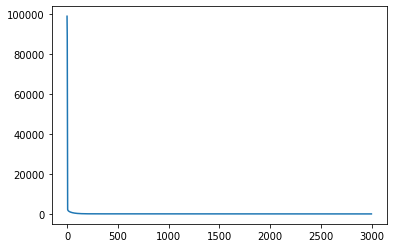

In [ ]:
updated_model, loss_history, _ = maml(inputs, loss_kwargs={'device':device}, max_grad_grad_norm=max_grad_grad_norm)
final_loss = loss_fn(updated_model, (batch, outputs), device=device)
final_loss.backward()
grads = [params.grad for params in model.parameters()]
print("Loss naive: %.4f" % final_loss.item())
# print(loss_history)
plt.plot(loss_history)

In [ ]:
inputs = None
outputs = None
batch = None
for data in landS2_train_data_loader:
    input_size = data.shape[1]
#     x = data[:,:-1].clone().detach()
    inner_loop_sample = data[:,:-1].clone().detach().to(dtype=torch.float)
#     print(inner_loop_sample)
    h_value = data[:,-1].clone().detach().to(dtype=torch.float)
    outputs = h_value.view(-1,1)
    inputs = [(inner_loop_sample, outputs)] * maml_steps
    batch = inner_loop_sample
    break

Loss naive: 5.3847
tensor([22542.8848])
tensor([22037.7461])
tensor([21483.9258])
tensor([20779.0586])
tensor([19827.2852])
tensor([18521.7539])
tensor([16766.3184])
tensor([14539.0469])
tensor([11949.4629])
tensor([9300.2637])
tensor([7015.4883])
tensor([5407.6880])
tensor([4493.4917])
tensor([4056.1531])
tensor([3856.5845])
tensor([3750.5867])
tensor([3676.6499])
tensor([3613.7922])
tensor([3555.5571])
tensor([3500.0164])
tensor([3446.5249])
tensor([3394.9109])
tensor([3344.7859])
tensor([3296.0435])
tensor([3248.4800])
tensor([3202.0259])
tensor([3156.5532])
tensor([3111.9570])
tensor([3068.1001])
tensor([3024.9517])
tensor([2982.4282])
tensor([2940.4663])
tensor([2899.0303])
tensor([2858.0396])
tensor([2817.5051])
tensor([2777.3894])
tensor([2737.6777])
tensor([2698.2490])
tensor([2659.1348])
tensor([2620.2222])
tensor([2581.6531])
tensor([2543.2786])
tensor([2505.2097])
tensor([2467.2937])
tensor([2429.6194])
tensor([2392.0762])
tensor([2354.7688])
tensor([2317.5674])
tensor([2280

tensor([22.1389])
tensor([22.1070])
tensor([22.0737])
tensor([22.0406])
tensor([22.0069])
tensor([21.9732])
tensor([21.9419])
tensor([21.9106])
tensor([21.8765])
tensor([21.8455])
tensor([21.8150])
tensor([21.7861])
tensor([21.7571])
tensor([21.7275])
tensor([21.6975])
tensor([21.6673])
tensor([21.6383])
tensor([21.6121])
tensor([21.5830])
tensor([21.5536])
tensor([21.5256])
tensor([21.4977])
tensor([21.4715])
tensor([21.4434])
tensor([21.4155])
tensor([21.3789])
tensor([21.3451])
tensor([21.3119])
tensor([21.2768])
tensor([21.2420])
tensor([21.2077])
tensor([21.1738])
tensor([21.1394])
tensor([21.1070])
tensor([21.0743])
tensor([21.0401])
tensor([21.0056])
tensor([20.9728])
tensor([20.9390])
tensor([20.9035])
tensor([20.8643])
tensor([20.8265])
tensor([20.7866])
tensor([20.7469])
tensor([20.7079])
tensor([20.6691])
tensor([20.6311])
tensor([20.5923])
tensor([20.5552])
tensor([20.5191])
tensor([20.4805])
tensor([20.4419])
tensor([20.4051])
tensor([20.3678])
tensor([20.3315])
tensor([20

tensor([12.2650])
tensor([12.2560])
tensor([12.2475])
tensor([12.2388])
tensor([12.2301])
tensor([12.2219])
tensor([12.2132])
tensor([12.2045])
tensor([12.1957])
tensor([12.1876])
tensor([12.1793])
tensor([12.1709])
tensor([12.1620])
tensor([12.1534])
tensor([12.1455])
tensor([12.1373])
tensor([12.1284])
tensor([12.1198])
tensor([12.1116])
tensor([12.1037])
tensor([12.0950])
tensor([12.0864])
tensor([12.0781])
tensor([12.0702])
tensor([12.0620])
tensor([12.0536])
tensor([12.0454])
tensor([12.0369])
tensor([12.0288])
tensor([12.0207])
tensor([12.0125])
tensor([12.0040])
tensor([11.9958])
tensor([11.9881])
tensor([11.9798])
tensor([11.9714])
tensor([11.9633])
tensor([11.9557])
tensor([11.9476])
tensor([11.9393])
tensor([11.9311])
tensor([11.9231])
tensor([11.9154])
tensor([11.9071])
tensor([11.8991])
tensor([11.8910])
tensor([11.8832])
tensor([11.8753])
tensor([11.8672])
tensor([11.8592])
tensor([11.8515])
tensor([11.8438])
tensor([11.8357])
tensor([11.8278])
tensor([11.8197])
tensor([11

tensor([8.9775])
tensor([8.9732])
tensor([8.9688])
tensor([8.9641])
tensor([8.9604])
tensor([8.9556])
tensor([8.9519])
tensor([8.9464])
tensor([8.9432])
tensor([8.9384])
tensor([8.9344])
tensor([8.9301])
tensor([8.9257])
tensor([8.9213])
tensor([8.9166])
tensor([8.9134])
tensor([8.9082])
tensor([8.9041])
tensor([8.9000])
tensor([8.8959])
tensor([8.8908])
tensor([8.8878])
tensor([8.8827])
tensor([8.8788])
tensor([8.8742])
tensor([8.8704])
tensor([8.8654])
tensor([8.8624])
tensor([8.8573])
tensor([8.8537])
tensor([8.8487])
tensor([8.8451])
tensor([8.8406])
tensor([8.8364])
tensor([8.8325])
tensor([8.8281])
tensor([8.8242])
tensor([8.8191])
tensor([8.8155])
tensor([8.8114])
tensor([8.8076])
tensor([8.8031])
tensor([8.7993])
tensor([8.7941])
tensor([8.7910])
tensor([8.7861])
tensor([8.7824])
tensor([8.7782])
tensor([8.7740])
tensor([8.7699])
tensor([8.7655])
tensor([8.7613])
tensor([8.7575])
tensor([8.7536])
tensor([8.7493])
tensor([8.7452])
tensor([8.7406])
tensor([8.7367])
tensor([8.7328

tensor([7.1091])
tensor([7.1063])
tensor([7.1034])
tensor([7.1012])
tensor([7.0978])
tensor([7.0954])
tensor([7.0924])
tensor([7.0899])
tensor([7.0864])
tensor([7.0839])
tensor([7.0815])
tensor([7.0785])
tensor([7.0760])
tensor([7.0727])
tensor([7.0703])
tensor([7.0672])
tensor([7.0648])
tensor([7.0616])
tensor([7.0595])
tensor([7.0561])
tensor([7.0538])
tensor([7.0507])
tensor([7.0480])
tensor([7.0453])
tensor([7.0425])
tensor([7.0400])
tensor([7.0367])
tensor([7.0344])
tensor([7.0313])
tensor([7.0290])
tensor([7.0254])
tensor([7.0233])
tensor([7.0206])
tensor([7.0177])
tensor([7.0152])
tensor([7.0120])
tensor([7.0095])
tensor([7.0064])
tensor([7.0042])
tensor([7.0011])
tensor([6.9991])
tensor([6.9957])
tensor([6.9932])
tensor([6.9901])
tensor([6.9875])
tensor([6.9849])
tensor([6.9822])
tensor([6.9797])
tensor([6.9764])
tensor([6.9743])
tensor([6.9709])
tensor([6.9685])
tensor([6.9657])
tensor([6.9632])
tensor([6.9604])
tensor([6.9575])
tensor([6.9551])
tensor([6.9518])
tensor([6.9497

tensor([5.8459])
tensor([5.8437])
tensor([5.8416])
tensor([5.8395])
tensor([5.8378])
tensor([5.8356])
tensor([5.8335])
tensor([5.8315])
tensor([5.8298])
tensor([5.8280])
tensor([5.8259])
tensor([5.8238])
tensor([5.8218])
tensor([5.8201])
tensor([5.8180])
tensor([5.8159])
tensor([5.8139])
tensor([5.8121])
tensor([5.8103])
tensor([5.8085])
tensor([5.8064])
tensor([5.8044])
tensor([5.8028])
tensor([5.8007])
tensor([5.7986])
tensor([5.7966])
tensor([5.7949])
tensor([5.7928])
tensor([5.7910])
tensor([5.7890])
tensor([5.7873])
tensor([5.7855])
tensor([5.7834])
tensor([5.7813])
tensor([5.7793])
tensor([5.7777])
tensor([5.7757])
tensor([5.7738])
tensor([5.7719])
tensor([5.7702])
tensor([5.7681])
tensor([5.7661])
tensor([5.7641])
tensor([5.7623])
tensor([5.7605])
tensor([5.7585])
tensor([5.7565])
tensor([5.7548])
tensor([5.7531])
tensor([5.7510])
tensor([5.7490])
tensor([5.7471])
tensor([5.7454])
tensor([5.7434])
tensor([5.7413])
tensor([5.7394])
tensor([5.7379])
tensor([5.7360])
tensor([5.7339

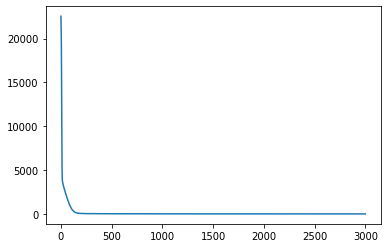

In [ ]:
updated_model, loss_history, _ = maml(inputs, loss_kwargs={'device':device}, max_grad_grad_norm=max_grad_grad_norm)
final_loss = loss_fn(updated_model, (batch, outputs), device=device)
final_loss.backward()
grads = [params.grad for params in model.parameters()]
print("Loss naive: %.4f" % final_loss.item())
for loss in loss_history:
    print(loss.data)
plt.plot(loss_history)